# Time series
75033710 rows

13713 unique time series taken in 12603 stations from 17-10-2000 to 22-03-2018

In [ ]:
#conda install -c conda-forge geoplot

In [1]:
import pyarrow.feather as feather
import pandas as pd
import numpy as np
from scipy.io import netcdf
import matplotlib.pyplot as plt 

In [2]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import xarray as xr
import netCDF4 as nc
from netCDF4 import Dataset

In [ ]:
# import freq level
freq_level = pd.read_csv("dataset/time_series/freq_level.csv")
freq_level.head()

In [ ]:
# import high freq t s
high_freq_t_s = pd.read_csv("dataset/time_series/high_freq_t_s.csv")
high_freq_t_s = high_freq_t_s.set_index("proj_id")
high_freq_t_s.columns = convert_col_to_date(high_freq_t_s.columns)
high_freq_t_s.head()

In [80]:
# import meta_data for the lat and long of bgr stations
meta_df = pd.read_excel("dataset/meta_data/metadata_timeseries_LongLat.xlsx")
bgr_location = meta_df[["proj_id","x_long","y_lat"]].sort_values("proj_id")
bgr_location = bgr_location.rename(columns={"x_long":"bgr_long","y_lat":"bgr_lat"})
bgr_location.head()

,proj_id,bgr_long,bgr_lat
0,BB_25470023,13.643609,53.416804
1,BB_25470024,13.643653,53.416793
2,BB_25480025,13.826532,53.452024
3,BB_25480026,13.677407,53.457078
4,BB_25481088,13.821475,53.475857


In [ ]:
bgr_location.shape

In [ ]:
# number of days in the period between 1995 and 2012
(pd.to_datetime("31.12.2012").date() - pd.to_datetime("01.01.1995").date()).days

# temperature: as predictor

### Daily means of hourly grids of air temperature for whole Germany (project TRY Advancement)

### there are 215 NC files, each file represents a month of dailly temperature from 01-1995 tp 11-2012

### each nc file has temperature across whole germany

In [3]:
# open a sample nc file to extract the weather stations lat/long
dir_01_2005 = "dataset/temperature/data/"+'daily_Project_TRY_air_temperature_mean__TT_200511_daymean.nc'
temp_01_2005 = netcdf.NetCDFFile(dir_01_2005,'r')

In [4]:
temp_01_2005.variables

OrderedDict([('lon', <scipy.io.netcdf.netcdf_variable at 0x7f06ec60d0a0>),
             ('lat', <scipy.io.netcdf.netcdf_variable at 0x7f06b25ad7f0>),
             ('time', <scipy.io.netcdf.netcdf_variable at 0x7f06ec606c70>),
             ('time_bnds',
              <scipy.io.netcdf.netcdf_variable at 0x7f06ec606880>),
             ('datum', <scipy.io.netcdf.netcdf_variable at 0x7f06b25bed30>),
             ('temperature',
              <scipy.io.netcdf.netcdf_variable at 0x7f06b25beb20>)])

In [ ]:
DS = xr.open_dataset(dir_01_2005)

In [ ]:
fn = "dataset/temperature/data/1.nc"
ds = nc.Dataset(fn, 'w', format='NETCDF4')

In [ ]:
DS.lat.values.flatten()
DS.temperature.values.flatten().shape

In [ ]:
DS.datum.values.flatten().shape

In [ ]:
DS.dims
#DS.coords
#DS.var

In [ ]:
DS.var

In [ ]:
#temp_01_2005.variables["temperature"][:,:,:].shape

In [7]:
weather_df = pd.DataFrame({"long":weather_long,"lat": weather_lat})#,"temp": temp})
weather_df.head()

,long,lat
0,5.5452,46.7198
1,5.5587,46.7204
2,5.5722,46.7209
3,5.5857,46.7215
4,5.5991,46.7221


In [13]:
weather_long0=weather_long[0]
weather_lat0=weather_lat[0]

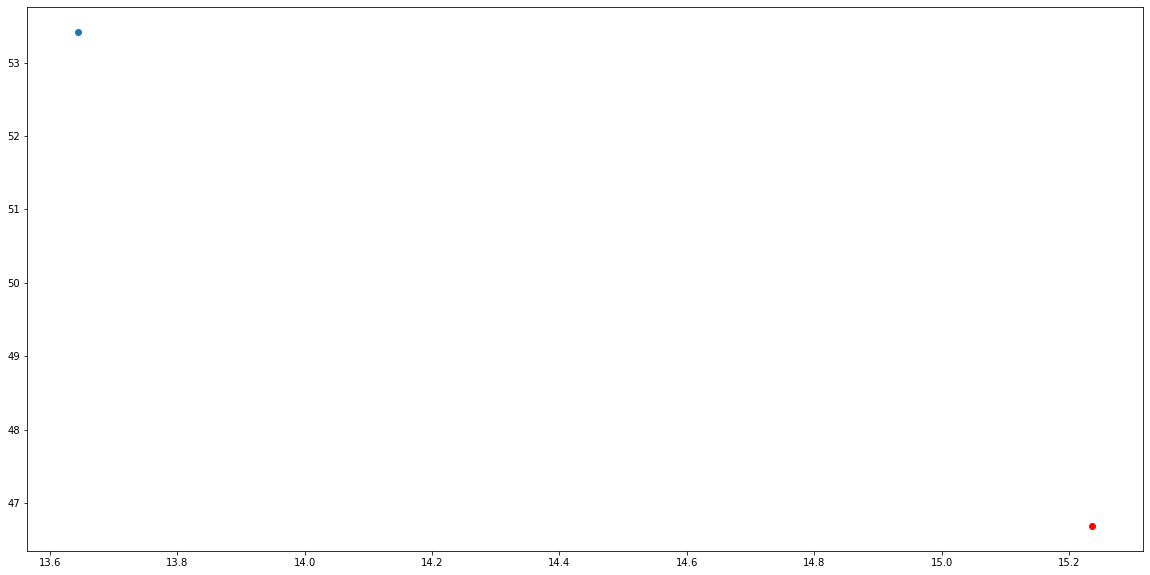

In [16]:
plt.figure(figsize=(20,10))
plt.scatter(x=bgr_lon, y=bgr_lat)
plt.scatter(x=15.236500, y=46.684500,color="red")
plt.show()

In [ ]:
# plot the bgr stations 13492 stations "red" and the weather stations 675360 stations "blue"
plt.figure(figsize=(20,10))
plt.scatter(x=weather_df['long'], y=weather_df['lat'])
plt.scatter(x=bgr_location['bgr_long'], y=bgr_location['bgr_lat'],color="red")
plt.show()

In [ ]:
# an example of bgr long
bgr_station_long = bgr_location["bgr_long"][5]
bgr_station_lat = bgr_location["bgr_lat"][5]
print(bgr_long0)
print(bgr_lat0)

In [ ]:
bgr_location.head()

In [ ]:
# my function which turned out that wronge because we can not walk on straight line on the long/lat on the sphere
def compute_colsest_weather_station(bgr_station_long, bgr_station_lat):
    
    #bgr_station_long = bgr_location["bgr_long"]
    #bgr_station_lat = bgr_location["bgr_lat"]
    print((bgr_station_long, bgr_station_lat))
    abs_long = np.absolute(weather_long - bgr_station_long)
    abs_lat = np.absolute(weather_lat - bgr_station_lat)
    
    
    if np.min(abs_long) <= np.min(abs_lat):
        min_long_indices = np.argwhere(abs_long == np.min(abs_long))
        idx = min_long_indices[abs_lat[min_long_indices] == np.min(abs_lat[min_long_indices])][0]
        #print(min_long_indices)
        #print(weather_long[idx])
        #print(weather_lat[idx])
    else:
        min_lat_indices = np.argwhere(abs_lat == np.min(abs_lat))
        idx = min_lat_indices[abs_long[min_lat_indices] == np.min(abs_long[min_lat_indices])][0]   
        #print(weather_long[idx])
        #print(weather_lat[idx])
        #print(min_lat_indices)
    #df["idx"]=idx
    return idx

In [ ]:
#bgr_location["idx"] = bgr_location.apply(lambda x: compute_colsest_weather_station(x["bgr_long"],x["bgr_lat"]),axis=1)
bgr_location.head()

In [ ]:
bgr_location["weath_long"]= bgr_location["idx"].apply(lambda x: weather_long[x])

In [ ]:
bgr_location["weath_lat"]= bgr_location["idx"].apply(lambda x: weather_lat[x])

In [ ]:
bgr_location.iloc[1020]

In [ ]:
np.argwhere(weather_long==13.8835)

In [ ]:
for i in np.argwhere(weather_long==13.8835):
    print(weather_lat[i])

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(bgr_location["bgr_lat"],bgr_location["weath_lat"])
plt.scatter( 52.3345,  54.1204, color="red")
#plt.scatter(x=lo, y=la,color="red")
plt.xlabel('bgr_station_lat')
plt.ylabel('weather_station_lat')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(bgr_location["bgr_long"],bgr_location["weath_long"])
#plt.scatter( 52.3345,  54.1204, color="red")
#plt.scatter(x=lo, y=la,color="red")
plt.xlabel('bgr_station_long')
plt.ylabel('weather_station_long')
plt.show()

In [ ]:
m = bgr_location["idx"]
lo = weather_long[m]
la = weather_lat[m]

In [ ]:
station = bgr_location.iloc[5400]
station

In [ ]:
weather_df.iloc[266575]

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(bgr_location["bgr_long"],bgr_location["bgr_lat"])
#plt.scatter( 52.3345,  54.1204, color="red")
#plt.scatter(x=lo, y=la,color="red")
plt.show()

In [ ]:
# the indicies computed once and stored 
station_temp_df["idx"] = station_temp_df.apply(temp_idx,axis=1) 
# station_temp_df.head()
#station_temp_df = station_temp_df.rename(columns={"Temp_20050103":"idx"})
# save in temporary dataset file for later use
#station_temp_df.to_csv("dataset/temporary/station_temp_df.csv", index=False)

In [ ]:
# create df for the lat/long of bgr station and corresponding to ind od weather station 
temp_df = pd.read_csv("dataset/temporary/station_temp_df.csv")
temp_df.head()

## important to open all nc and extract temp

In [ ]:
# pathes to all nc files
from os import walk
folder_path =  "dataset/project_try_dwd/data/"
files= []
for (dirpath, dirnames, filenames) in walk(folder_path):
    files.extend(filenames)
    break
files[:2]

In [ ]:
# extract temps in each day of each nc file at the corresponding lat/longfor all months
for file in files:
    month = folder_path + file
    nc_file = netcdf.NetCDFFile(month,'r')
    days = nc_file.variables["datum"][:]
    days = [str(x)[:-4] for x in days]
    for d, day in enumerate(days):
        #if day in unique_dates:
        temp_df[str(day)] = nc_file.variables["temperature"][d,:,:].flatten()[temp_df["idx"]]


In [ ]:
a =temp_01_2005.variables["temperature"][5,:,:].flatten()[temp_df["idx"]]

In [ ]:
len(a[a==9999])

In [ ]:
b =temp_01_2005.variables["temperature"][20,:,:].flatten()[]
b

In [ ]:
long = df["x_long"]
lat  = df["y_lat"]
# compute the closest temp_long to the station- all occurances
a = np.absolute(x_long - long)
# compute the closest temp_lat to the station- all occurances
b = np.absolute(y_lat - lat)

if np.min(a) <= np.min(b):
    min_long = np.argwhere(a == np.min(a))
    idx = [int(i) for i in min_long if b[i] == np.min(b[min_long])][0]

else:
    min_lat = np.argwhere(b == np.min(b))
    idx = [int(i) for i in min_lat if a[i] == np.min(a[min_lat])][0]


In [ ]:
dirc = "dataset/project_try_dwd/data/"+files[0]
dirc

In [ ]:
plt.figure(figsize=(50,15))
t_s_1.plot(color='blue', grid=True)
plt.legend(loc='upper left')
plt.xlabel('t s temp_BB_25470023 ')
temp_BB_254700230.plot(color='red', grid=True, secondary_y=True)
plt.legend(loc='upper right')
plt.xlabel('temp temp_BB_25470023 ')
plt.show()

In [58]:
weather_df.head()

,long,lat,dist
0,5.5452,46.7198,34.053141
1,5.5587,46.7204,34.050516
2,5.5722,46.7209,34.047799
3,5.5857,46.7215,34.045184
4,5.5991,46.7221,34.042598


In [60]:
geometry = [Point(xy) for xy in zip(weather_df['long'], weather_df['lat'])]
gdf = GeoDataFrame(weather_df, geometry=geometry)
gdf.head()

,long,lat,dist,geometry
0,5.5452,46.7198,34.053141,POINT (5.54520 46.71980)
1,5.5587,46.7204,34.050516,POINT (5.55870 46.72040)
2,5.5722,46.7209,34.047799,POINT (5.57220 46.72090)
3,5.5857,46.7215,34.045184,POINT (5.58570 46.72150)
4,5.5991,46.7221,34.042598,POINT (5.59910 46.72210)


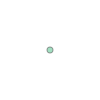

In [66]:
gdf.geometry[0]

In [ ]:
geometry = [Point(xy) for xy in zip(weather_df['long'], weather_df['lat'])]
gdf = GeoDataFrame(weather_df, geometry=geometry)

plt.rcParams['figure.figsize'] = [16, 11]
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='orange', alpha=0.8)
gdf.plot(ax=ax, color='orange', alpha=0.8)

gdf.head()

In [30]:
bgr = (bgr_lat,bgr_lon)
bgr

(53.416793, 13.643653)

In [32]:
weather= (weather_lat0,weather_lat0)
weather

(46.7198, 46.7198)

In [42]:
def distance(x,y):
    pt_1 =(x,y)
    pt_1 = np.array((pt_1[0], pt_1[1]))
    pt_2 = np.array((bgr[0], bgr[1]))
    return np.linalg.norm(pt_1-pt_2)


In [53]:
#weather_df["dist"]=weather_df.apply(lambda x:distance(weather_df["long"],weather_df["lat"]),axis=1)

In [17]:
def distance(pt_1, pt_2):
    pt_1 = np.array((pt_1[0], pt_1[1]))
    pt_2 = np.array((pt_2[0], pt_2[1]))
    return np.linalg.norm(pt_1-pt_2)

def closest_node(node, df):
    pt = []
    nodes = zip(weather_df["long"],weather_df["long"])
    dist = 9999999
    for n in nodes:
        if distance(node, n) <= dist:
            dist = distance(node, n)
            pt =n 
    return pt


In [68]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def distance(df,bgr):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1 = df["long"], df["lat"]
    lon2, lat2 = bgr
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


In [76]:
#del weather_df["geometry"]

In [81]:
def inx_bgr(df):
    bgr = df["bgr_long"], df["bgr_lat"]
    weather_df["dist"]= weather_df.apply(distance, axis=1)
    return np.argmin(weather_df["dist"])

In [82]:
bgr_location["idx"]=bgr_location.apply(inx_bgr, axis=1)

KeyboardInterrupt: 

In [83]:
bgr_location.head()

,proj_id,bgr_long,bgr_lat
0,BB_25470023,13.643609,53.416804
1,BB_25470024,13.643653,53.416793
2,BB_25480025,13.826532,53.452024
3,BB_25480026,13.677407,53.457078
4,BB_25481088,13.821475,53.475857
